In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rng="Sobol", 
         mode="unipolar", 
         bitwidth=8, 
         jk_trace=False, 
         emit=True, 
         total_cnt=100, 
         depth_kernel=1, 
         depth_sr=2, 
         savepdf=False):
    stype = torch.float
    rtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)

    output = torch.sqrt(input).to(device)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        outputPE = ProgressiveError(output, mode=mode).to(device)
    
        inputPE  = ProgressiveError(input,  mode=mode).to(device)
        inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)

        dut_sqrt = UnarySqrt(mode=mode, 
                         jk_trace=jk_trace, 
                         depth_kernel=depth_kernel, 
                         rng="SYS", 
                         rng_dim=4, 
                         emit=emit, 
                         depth_sr=depth_sr, 
                         stype=torch.float).to(device)
        
        inputRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                ouyput_bs = dut_sqrt(input_bs)
                outputPE.Monitor(ouyput_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(math.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    avg_total = np.mean(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    plt.tight_layout()
    plt.xlabel('Input value')
    plt.ylabel('Output error')
    plt.xticks(np.arange(0, 1.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.xlim(0, 1)
    plt.yticks(np.arange(-0.2, 0.4, step=0.2))
    # ax.yaxis.set_ticklabels([])
    plt.ylim(-0.3, 0.55)
    plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
    fig.set_size_inches(2, 2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if savepdf is True:
        if emit is True:
            plt.savefig("sqrt-"+mode+"-bw"+str(bitwidth)+"-bit"+"-emitting"+"-sr"+str(depth_sr)+"-k"+str(depth_kernel)+".pdf", 
                        dpi=300, 
                        bbox_inches='tight')
        else:
            if jk_trace is True:
                plt.savefig("sqrt-"+mode+"-bw"+str(bitwidth)+"-bit"+"-inserting-JK"+".pdf", 
                            dpi=300, 
                            bbox_inches='tight')
            else:
                plt.savefig("sqrt-"+mode+"-bw"+str(bitwidth)+"-bit"+"-inserting-IS"+"-k"+str(depth_kernel)+".pdf", 
                            dpi=300, 
                            bbox_inches='tight')
    plt.show()
    plt.close()

# performance comparison
## bit-inseting and bit-emitting

unipolar, bit-emitting
unipolar
RMSE:0.05213
MAE: 0.02406
bias:-0.01654
max: 0.9375
min: -0.1146


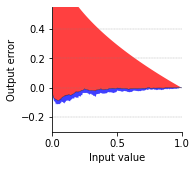

unipolar, bit-inserting-JK
unipolar
RMSE:0.1082
MAE: 0.08809
bias:-0.08808
max: 0.002001
min: -0.2005


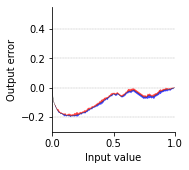

unipolar, bit-inserting-IS
unipolar
RMSE:0.1237
MAE: 0.105
bias:-0.105
max: 0.00211
min: -0.2223


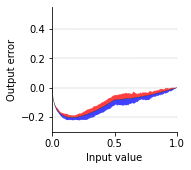

bipolar, bit-emitting
bipolar
RMSE:0.1011
MAE: 0.08308
bias:-0.0821
max: 0.09375
min: -0.2076


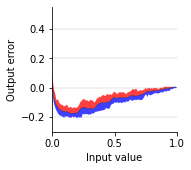

bipolar, bit-inserting-JK
bipolar
RMSE:0.1137
MAE: 0.09873
bias:-0.09808
max: 0.1094
min: -0.2476


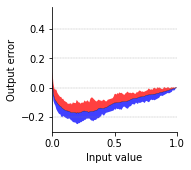

bipolar, bit-inserting-IS
bipolar
RMSE:0.1207
MAE: 0.1013
bias:-0.0941
max: 1.0
min: -0.2398


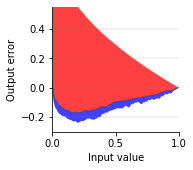

In [5]:
print("unipolar, bit-emitting")
test(rng="LFSR", mode = "unipolar", bitwidth = 8, emit = True, jk_trace = False, depth_kernel=1, depth_sr=4, savepdf=False)
print("unipolar, bit-inserting-JK")
test(rng="LFSR", mode = "unipolar", bitwidth = 8, emit = False, jk_trace = True, depth_kernel=1, depth_sr=2, savepdf=False)
print("unipolar, bit-inserting-IS")
test(rng="LFSR", mode = "unipolar", bitwidth = 8, emit = False, jk_trace = False, depth_kernel=1, depth_sr=2, savepdf=False)

print("bipolar, bit-emitting")
test(rng="LFSR", mode = "bipolar", bitwidth = 8, emit = True, jk_trace = False, depth_kernel=1, depth_sr=4, savepdf=False)
print("bipolar, bit-inserting-JK")
test(rng="LFSR", mode = "bipolar", bitwidth = 8, emit = False, jk_trace = True, depth_kernel=1, depth_sr=2, savepdf=False)
print("bipolar, bit-inserting-IS")
test(rng="LFSR", mode = "bipolar", bitwidth = 8, emit = False, jk_trace = False, depth_kernel=1, depth_sr=2, savepdf=False)